# Main results from subnational P budget calculation for EU28

This notebook loads and compiles the results from the other parts of the calculation. It produces the publication figures and lists a few numerical results reported in the paper.

In [1]:
import pandas as pd
import geopandas
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import nuts
import settings
import plots
import eust

In [2]:
nuts_table = nuts.get_nuts_candidates()
EU28_countries = list(nuts_table.country_code.unique())

In [3]:
refareas = pd.read_csv(settings.REFERENCE_AREAS_PATH, index_col='geo')
refareas

,UAA,UAA_XJ2000_J3000
geo,,
AT,2.72689,2.28822
AT1,1.09884,1.08506
AT11,0.18197,0.17671
AT12,0.90885,0.90100
AT13,0.00802,0.00735
...,...,...
UKM3,0.79834,0.48694
UKM5,0.47877,0.31144
UKM6,2.76356,0.43391


In [4]:
harvest = pd.read_csv(settings.HARVEST_PATH, index_col='geo')
harvest

,UAA,UAA_XJ2000_J3000
geo,,
AT,34.822616,31.372186
AT1,15.792107,15.704185
AT11,2.432277,2.405337
AT12,13.916372,13.861194
AT13,0.097659,0.096332
...,...,...
UKM3,13.680010,8.397701
UKM5,8.409825,5.636565
UKM6,47.173386,7.513101


In [5]:
excretion = pd.read_csv(settings.EXCRETION_PATH, index_col='geo').excretion
excretion

geo
AT      27.834650
AT11     0.395425
AT12     6.347312
AT13     0.002201
AT21     2.369130
          ...    
UKM2    10.211552
UKM3    11.429717
UKM5     4.001366
UKM6     6.979625
UKN0    23.973491
Name: excretion, Length: 286, dtype: float64

In [6]:
mineral = pd.read_csv(settings.MINERAL_FERTILIZER_PATH, index_col='geo').mineral
mineral

geo
AT      17.261000
AT1      6.955574
AT11     1.341202
AT12     7.997492
AT13     0.050766
          ...    
UKM3     3.771635
UKM5     2.261876
UKM6    13.056016
UKN      2.735834
UKN0     2.735834
Name: mineral, Length: 427, dtype: float64

# Gather quantities for refarea alternatives

In [7]:
quantities_all = {
    k: pd.DataFrame(
        dict(
            harvest=harvest[k],
            excretion=excretion,
            mineral=mineral,
            refarea=refareas[k],
        )
    )
    .reindex(nuts_table.index)
    for k in refareas.columns
}
quantities_all

{'UAA':         harvest  excretion    mineral  refarea
 geo                                           
 AT    34.822616  27.834650  17.261000  2.72689
 AT1   15.792107        NaN   6.955574  1.09884
 AT11   2.432277   0.395425   1.341202  0.18197
 AT12  13.916372   6.347312   7.997492  0.90885
 AT13   0.097659   0.002201   0.050766  0.00802
 ...         ...        ...        ...      ...
 UKM3  13.680010  11.429717   3.771635  0.79834
 UKM5   8.409825   4.001366   2.261876  0.47877
 UKM6  47.173386   6.979625  13.056016  2.76356
 UKN   17.927024        NaN   2.735834  1.04614
 UKN0  17.927024  23.973491   2.735834  1.04614
 
 [390 rows x 4 columns],
 'UAA_XJ2000_J3000':         harvest  excretion    mineral  refarea
 geo                                           
 AT    31.372186  27.834650  17.261000  2.28822
 AT1   15.704185        NaN   6.955574  1.08506
 AT11   2.405337   0.395425   1.341202  0.17671
 AT12  13.861194   6.347312   7.997492  0.90100
 AT13   0.096332   0.002201   0.05

# Calculate rates (quantity / refarea)

In [8]:
rates_all = {
    k: v.div(v["refarea"], axis=0).drop(columns="refarea").join(v["refarea"])
    for k, v in quantities_all.items()
}
rates_all

{'UAA':         harvest  excretion   mineral  refarea
 geo                                          
 AT    12.770085  10.207471  6.329922  2.72689
 AT1   14.371617        NaN  6.329924  1.09884
 AT11  13.366362   2.173025  7.370455  0.18197
 AT12  15.312067   6.983894  8.799573  0.90885
 AT13  12.176923   0.274447  6.329915  0.00802
 ...         ...        ...       ...      ...
 UKM3  17.135569  14.316853  4.724347  0.79834
 UKM5  17.565480   8.357596  4.724347  0.47877
 UKM6  17.069789   2.525592  4.724347  2.76356
 UKN   17.136353        NaN  2.615170  1.04614
 UKN0  17.136353  22.916140  2.615170  1.04614
 
 [390 rows x 4 columns],
 'UAA_XJ2000_J3000':         harvest  excretion    mineral  refarea
 geo                                           
 AT    13.710301  12.164324   7.543418  2.28822
 AT1   14.473102        NaN   6.410312  1.08506
 AT11  13.611777   2.237708   7.589846  0.17671
 AT12  15.384233   7.044742   8.876239  0.90100
 AT13  13.106439   0.299465   6.906927  0.00735

# Calculate surplus per hectare

In [9]:
def calculate_surplus(quantities):
    return quantities.eval('(excretion + mineral - harvest) / refarea')

surplus_all = {
    k: v.pipe(calculate_surplus)
    for k, v in quantities_all.items()
}

# Compare country-level surplus calculated on different NUTS levels

If the data are consistent and have sufficiently high coverage, the results should agree rather closely but need not be exactly identical.

In [10]:
def country_sum_on_level(d, nuts_level):
    return (
        d
        .pipe(nuts.filter_nuts_level, nuts_level)
        .join(nuts_table.country_code)
        .groupby('country_code')
        .apply(lambda g: g.sum(skipna=False))
    )

def country_sum_on_levels(d, nuts_levels):
    return pd.concat(
        {
            nuts_level: country_sum_on_level(d, nuts_level)
            for nuts_level in nuts_levels
        },
        axis=1
    )

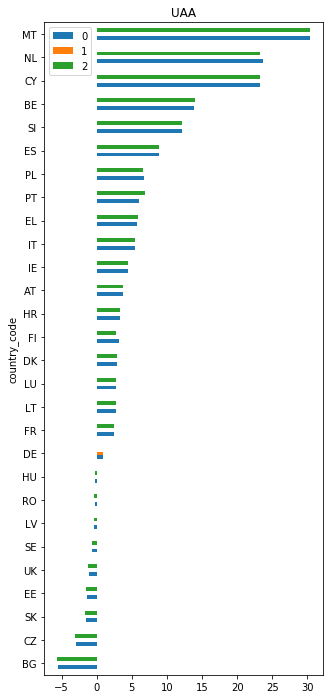

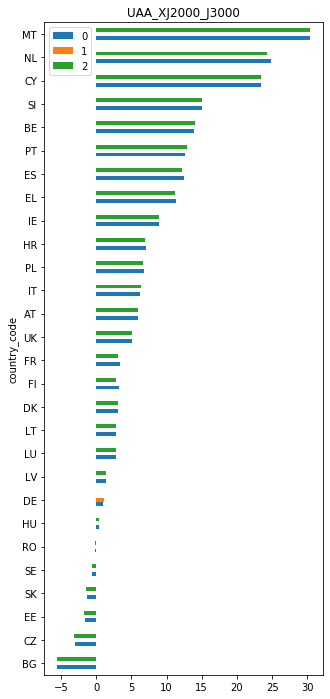

In [11]:
nuts_levels = [0, 1, 2]

for variant, q in quantities_all.items():
    ax = (
        country_sum_on_levels(q, nuts_levels)
        .stack(0)
        .pipe(calculate_surplus)
        .unstack()
        .sort_values(0)
        .plot
        .barh(figsize=(5, 12))
    )
    ax.set_title(variant)

# Select NUTS level to use for each country

In [12]:
selected_nuts_level = (
    pd.Series(
        {
            **{k: 2 for k in EU28_countries},
            **{'DE': 1}, # exceptions
        },
    )
    .rename_axis('country_code')
    .rename('nuts_level')
)

selected_regions = (
    nuts_table
    .reset_index()
    .merge(selected_nuts_level.reset_index(), on=['country_code', 'nuts_level'], how='inner')
    .set_index('geo')
    .index
)
selected_regions

def get_selected_subset(d, level=None):
    return d.reindex(selected_regions, level=level)

In [13]:
selected_regions

Index(['AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34',
       'BE10',
       ...
       'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM2', 'UKM3', 'UKM5', 'UKM6',
       'UKN0'],
      dtype='object', name='geo', length=243)

In [14]:
quantities = {
    k: v.pipe(get_selected_subset)
    for k, v in quantities_all.items()
}

rates = {
    k: v.pipe(get_selected_subset)
    for k, v in rates_all.items()
}

surplus = {
    k: v.pipe(get_selected_subset)
    for k, v in surplus_all.items()
}

# Prepare for plotting

In [15]:
nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID')

def plot_variable_choropleth(s, ax=None, **kwargs):
    key = s.name
    
    d = nuts_geo[['geometry']].join(s, how='inner')
    
    kwargs_final = {
        'legend_kws': {
            'loc': 'upper left',
            'bbox_to_anchor': (1.05, 1.1),
            'borderaxespad': 0,
            'frameon': False,
            'title': 'kg P / ha',
        },
        **plots.CHOROPLETH_KWS[key],
        **kwargs,
    }
    
    ax = plots.plot_europe_choropleth(d, key, ax=ax, **kwargs_final)
    return ax

In [16]:
# Figure sizes etc
COLWIDTH = 76 / 25.4
TEXTWIDTH = 160 / 25.4

sns.set_style('darkgrid')
sns.set(
    font="Arial",
    rc={
        "xtick.labelsize": 8.5,
        "ytick.labelsize": 8.5,
        "axes.titlesize": 9,
        "axes.labelsize": 8.5,
        "legend.title_fontsize": 8.5,
        "legend.fontsize": 8.5,
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "mathtext.rm": "Arial",
        "mathtext.fontset": "custom",
        "axes.facecolor": "#eaeaea",
    },
)


def adjust_print_plot(fig, **kwargs):
    defaults = dict(left=0, bottom=0, right=1, top=0.97, wspace=0.05, hspace=0.05)
    
    fig.subplots_adjust(**{**defaults, **kwargs})

# Plot surplus terms

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


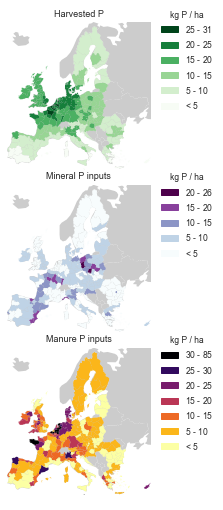

In [17]:
fig, axs = plt.subplots(nrows=3, figsize=(COLWIDTH, COLWIDTH * 2.3))

subplots = [
    dict(
        title='Harvested P',
        variable='harvest',
    ),
    dict(
        title='Mineral P inputs',
        variable='mineral',  
    ),
    dict(
        title='Manure P inputs',
        variable='excretion',
    )
]

for ax, sp in zip(axs, subplots):
    variable = sp['variable']
    plot_variable_choropleth(        
        rates['UAA'][variable].rename(variable),
        ax=ax,
    )
    ax.set_title(sp['title'])
    
adjust_print_plot(fig, right=0.7)
fig.savefig('outdata/figures/Fig2.pdf')

# Plot surplus with both reference areas

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is t

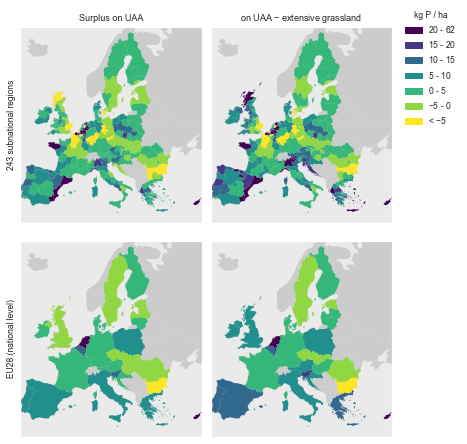

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(TEXTWIDTH, COLWIDTH * 2))

subplots = [
    dict(
        title='Surplus on UAA',
        dataset=surplus['UAA'],
        legend=False,
        ylabel=f"{len(surplus['UAA'])} subnational regions",
    ),
    dict(
        title='on UAA $-$ extensive grassland',
        dataset=surplus['UAA_XJ2000_J3000'],
        legend=True,   
        ylabel=None,
    ),
    dict(
        title=None,
        dataset=surplus_all['UAA'].reindex(EU28_countries),
        legend=False,
        ylabel='EU28 (national level)',
    ),
    dict(
        title=None,
        dataset=surplus_all['UAA_XJ2000_J3000'].reindex(EU28_countries),
        legend=False,
        ylabel=None,
    )
]

for ax, sp in zip(axs.flat, subplots):
    plot_variable_choropleth(
        sp['dataset'].rename('surplus'),
        legend=sp['legend'],
        ax=ax,
    )
    ax.set_title(sp['title'])
    ax.set_ylabel(sp['ylabel'])
    ax.axis('on')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    
adjust_print_plot(fig, right=0.85, left=0.03)
fig.savefig('outdata/figures/Fig3.pdf')

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


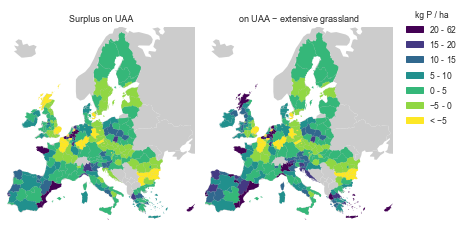

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(TEXTWIDTH, COLWIDTH * 1.1))

subplots = [
    dict(
        title='Surplus on UAA',
        variant='UAA',
        legend=False,
    ),
    dict(
        title='on UAA $-$ extensive grassland',
        variant='UAA_XJ2000_J3000',
        legend=True,        
    )    
]

for ax, sp in zip(axs, subplots):
    plot_variable_choropleth(
        surplus[sp['variant']].rename('surplus'),
        legend=sp['legend'],
        ax=ax,
    )
    ax.set_title(sp['title'])
    
adjust_print_plot(fig, right=0.85)
fig.savefig('outdata/figures/Fig3b.pdf')

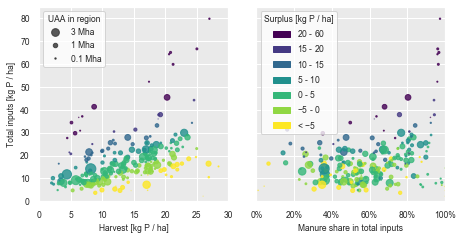

In [20]:
import mapclassify

surplus_scheme = mapclassify.UserDefined(
    surplus['UAA'],
    plots.CHOROPLETH_KWS['surplus']['bin_uls'],
)
surplus_cmap = plots.CHOROPLETH_KWS['surplus']['cmap']
surplus_fmt = plots.CHOROPLETH_KWS['surplus']['legend_fmt']

binned_surplus = pd.Series(data=surplus_scheme.yb, index=surplus['UAA'].index).rename('binned_surplus')
marker = 'o'
area_scale = 20
alpha = 0.8

scatter_data = (
    rates['UAA']
    .join(binned_surplus)
    .join(refareas['UAA'].rename('UAA').mul(area_scale))
    .assign(
        input_sum=lambda d: d.mineral + d.excretion,
        frac_manure=lambda d: d.excretion / d.input_sum
    )
)
scatter_data = scatter_data.sample(len(scatter_data), replace=False) # shuffle randomly

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(TEXTWIDTH, COLWIDTH * 1.1))

harvest_ax, frac_ax = axs

axs[0].set_ylabel('Total inputs [kg P / ha]')


harvest_ax.scatter(
    x='harvest',
    y='input_sum',
    c='binned_surplus',
    s='UAA',
    cmap=surplus_cmap,
    data=scatter_data,
    marker=marker,
    alpha=alpha,
)

harvest_ax.set_xlabel('Harvest [kg P / ha]')
harvest_ax.set_xlim(0, 30)

for ax in axs:
    ax.set_ylim(0, 85)


frac_ax.scatter(
    x='frac_manure',
    y='input_sum',
    c='binned_surplus',
    s='UAA',
    cmap=surplus_cmap,
    data=scatter_data,
    marker=marker,
    alpha=alpha,
)

frac_ax.set_xlabel('Manure share in total inputs')
frac_ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
frac_ax.set_xlim(0, 1)

frac_ax.legend(
    handles=plots.make_legend_handles(surplus_scheme, surplus_cmap, fmt=surplus_fmt),
    title='Surplus [kg P / ha]',
    facecolor='#ffffff',
    framealpha=0.8,
    bbox_to_anchor=(0, 1),
    loc='upper left',
)

reference_areas = [0.1, 1, 3]
size_patches = [
    mpl.lines.Line2D(
        markersize=(area * area_scale)**0.5,
        lw=0,
        marker=marker,
        xdata=[],
        ydata=[],
        color='#303030',
        alpha=alpha,
        label=f'{area:,g} Mha',
    )
    for area in reference_areas
]

harvest_ax.legend(
    handles=size_patches[::-1],
    facecolor='#ffffff',
    framealpha=0.8,
    bbox_to_anchor=(0, 1),
    loc='upper left',
    title="UAA in region",
)


adjust_print_plot(fig, left=0.08, right=0.975, bottom=0.15, wspace=0.15)

fig.savefig('outdata/figures/Fig4.pdf')

In [21]:
eurostat_gnb = (
    eust.read_table_data('aei_pr_gnb', version='2019-05-22 23:00:00')
    .value
    .xs('P', level='nutrient')
    .xs(settings.DATA_YEAR, level='time')
    .unstack('indic_ag')
)

eurostat_surplus = (
    eurostat_gnb
    .eval('BAL / UAA')
    .rename('Eurostat')
)

In [22]:
# From Fig. 4 in van Dijk et al. (2016) Sci. Tot. Env. 542 pp. 1078-1093
vanDijk_surplus = (
    pd.Series(
        {
            'BE': 23.2,
            'NL': 21.9,
            'PT': 13.2,
            'DK': 10.1,
            'ES': 9.0,
            'IT': 7.5,
            'PL': 7.4,
            'FI': 7.4,
            'IE': 6.7,
            'LU': 6.1,
            'EL': 5.9,
            'UK': 4.2,
            'FR': 3.8,
            'DE': 1.8,
            'LT': 0.8,
            'SE': 0.5,
            'BG': -0.1,
            'AT': -0.1,
            'SI': -0.4,
            'LV': -0.9,
            'HU': -1.0,
            'EE': -1.1,
            'CZ': -2.1,
            'SK': -2.8,
        }
    )
    .rename('van Dijk et al.')
    .rename_axis('geo')
)

In [23]:
def abbr_country(d, key='country'):
    return d.replace({key: {'United Kingdom': 'UK', 'Czech Republic': 'Czech Rep.'}})

national_comparison_data = (
    eurostat_surplus.to_frame()
    .join(surplus_all['UAA'].rename('Whole UAA'), how='inner')
    .join(surplus_all['UAA_XJ2000_J3000'].rename('Excl. extensive grass'), how='inner')
    .join(vanDijk_surplus)
    .rename_axis('source', axis=1)
    .assign()
    .stack()
    .rename('surplus')
    .reset_index()
    .join(nuts_table['country'], on='geo')
    .pipe(abbr_country)
    .set_index(['source', 'geo'])
    .sort_values('surplus')
    .reindex(
        [
            'Whole UAA',
            'Excl. extensive grass',
            'Eurostat',
            'van Dijk et al.',
        ],
        level='source'
    )
    .reset_index()
)

national_comparison_data

,source,geo,surplus,country
0,Whole UAA,BG,-5.564341,Bulgaria
1,Whole UAA,CZ,-2.960767,Czech Rep.
2,Whole UAA,SK,-1.484379,Slovakia
3,Whole UAA,EE,-1.344271,Estonia
4,Whole UAA,UK,-1.055570,UK
...,...,...,...,...
103,van Dijk et al.,ES,9.000000,Spain
104,van Dijk et al.,DK,10.100000,Denmark
105,van Dijk et al.,PT,13.200000,Portugal
106,van Dijk et al.,NL,21.900000,Netherlands


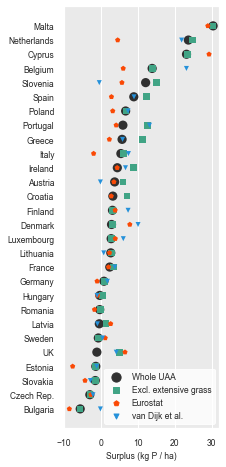

In [24]:
fig, ax = plt.subplots(figsize=(COLWIDTH, COLWIDTH * 2.2))

# Plot the national average surpluses
sns.scatterplot(
    x='surplus',
    y='country',
    hue='source',
    style='source',
    size='source',
    data=national_comparison_data,
    ax=ax,
    palette={
        'Whole UAA': '#303030',
        'Excl. extensive grass': sns.set_hls_values('#66c2a5', l=0.45),
        'Eurostat': sns.set_hls_values('#fc8d62', l=0.5),
        'van Dijk et al.': sns.set_hls_values('#1f78b4', l=0.5),
    },
    sizes={
        'Whole UAA': 85,
        'Excl. extensive grass': 45,
        'Eurostat': 30,
        'van Dijk et al.': 25,
    },
    markers={
        'Whole UAA': 'o',
        'Excl. extensive grass': 's',
        'Eurostat': 'p',
        'van Dijk et al.': 'v',
    },
    linewidth=0,
)

ax.set_ylabel(None)
ax.set_xlabel('Surplus (kg P / ha)')
ax.grid(True, axis='x')
ax.grid(False, axis='y')
adjust_print_plot(fig, left=0.27, bottom=0.1, right=0.99, top=0.99)
ax.set_xlim(-10, 32)

# Hack to remove seaborn's legend title which is added as a legend entry
h, l = ax.get_legend_handles_labels()
ax.legend(h[1:], l[1:], loc='lower right')
legend = ax.get_legend()
legend.get_frame().set_color('#ffffff')
legend.get_frame().set_alpha(0.8)
fig.savefig('outdata/figures/Fig5.pdf')

# Plot subnational points for both reference areas

In [25]:
subnational_comparison_data = (
    pd.DataFrame(surplus)
    .rename(columns={'UAA': 'Whole UAA', 'UAA_XJ2000_J3000': 'Excl. extensive grass'})
    .join(nuts_table.country)
    .reset_index()
    .pipe(abbr_country)
    .set_index(['country', 'geo'])
    .reindex(national_comparison_data.country.unique(), level='country')
    .rename_axis('variant', axis=1)
    .stack()
    .rename('surplus')
    .reset_index()
)
subnational_comparison_data

,country,geo,variant,surplus
0,Bulgaria,BG31,Whole UAA,-6.658438
1,Bulgaria,BG31,Excl. extensive grass,-6.833965
2,Bulgaria,BG32,Whole UAA,-7.174122
3,Bulgaria,BG32,Excl. extensive grass,-7.335999
4,Bulgaria,BG33,Whole UAA,-8.112668
...,...,...,...,...
481,Netherlands,NL41,Excl. extensive grass,62.066591
482,Netherlands,NL42,Whole UAA,52.820602
483,Netherlands,NL42,Excl. extensive grass,55.157117
484,Malta,MT00,Whole UAA,30.416226


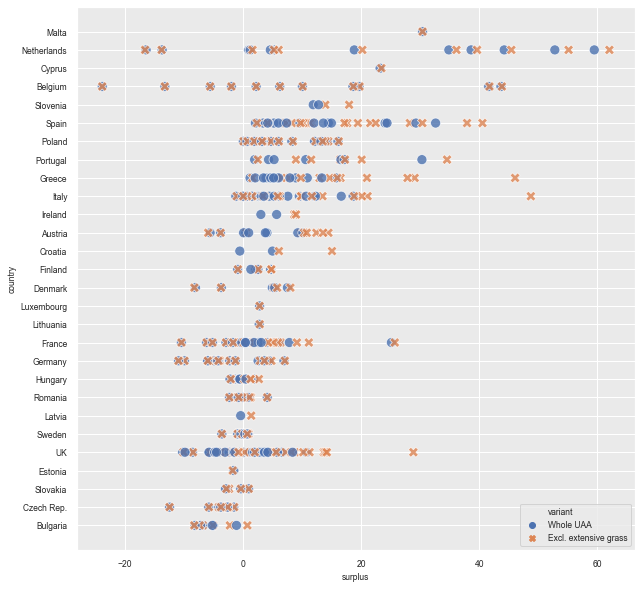

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x='surplus',
    y='country',
    hue='variant',
    style='variant',
    data=subnational_comparison_data,
    alpha=0.8,
    s=100,
    ax=ax,
)

# List some areas with large surpluses or deficits

In [27]:
substantial_area = quantities['UAA'].refarea > 0.1
surplus_subset = (
    surplus['UAA']
    .rename('surplus')
    .loc[substantial_area]
    .to_frame()
    .join(quantities['UAA'].refarea.rename('UAA'), how='inner')
)

In [28]:
surplus_subset.loc[lambda s: s.surplus > 20]

,surplus,UAA
geo,,
BE25,41.617494,0.20349
CY00,23.219979,0.10933
ES51,32.626557,1.12527
ES52,24.074870,0.63775
ES62,29.297010,0.37586
FR52,25.139818,1.64367
NL21,38.635423,0.19873
NL22,44.244273,0.23244
NL41,59.505755,0.24690


In [29]:
surplus_subset.loc[lambda s: s.surplus < -5]

,surplus,UAA
geo,,
BG31,-6.658438,0.93677
BG32,-7.174122,0.79343
BG33,-8.112668,0.82223
BG34,-5.018984,0.84516
BG41,-5.185342,0.55447
CZ04,-5.806313,0.31235
DE7,-5.979707,0.77189
DEB,-5.915808,0.70695
DEE,-5.983547,1.17278


In [30]:
deficit_but_high_inputs = rates['UAA'][surplus['UAA'] < 0].loc[lambda d: (d.excretion + d.mineral) > 15]
deficit_but_high_inputs

,harvest,excretion,mineral,refarea
geo,,,,
BE24,24.904105,16.743099,2.604349,0.08517
BE31,28.491726,9.474991,5.779955,0.05948
BE32,25.025894,17.277849,5.779973,0.20318
DE8,21.413519,7.025918,12.131105,1.34096
DED,18.624627,9.459665,7.851616,0.90663
DEE,21.314034,6.991675,8.338812,1.17278
DEG,20.718408,8.206681,8.243635,0.78067
DK01,20.573023,11.708221,5.192530,0.09848
FR10,22.677587,1.064298,15.433189,0.57164


In [31]:
deficit_but_high_inputs.refarea.sum()

16.80834

# List France example

In [32]:
(
    surplus_all['UAA']['FR':'FRX']
    .rename('surplus')
    .round(1)
    .to_frame()
    .join(nuts_table)
    .join(refareas['UAA'])
    .sort_values('surplus')
    .dropna()
)

,surplus,country_code,nuts_level,label,parent_geo,country,UAA
geo,,,,,,,
FR22,-10.4,FR,2,Picardie,FR2,France,1.31662
FR10,-6.2,FR,2,Île de France,FR1,France,0.57164
FR30,-5.2,FR,2,Nord - Pas-de-Calais,FR3,France,0.81338
FR24,-2.9,FR,2,Centre,FR2,France,2.30291
FR26,-1.8,FR,2,Bourgogne,FR2,France,1.74550
FR21,-0.5,FR,2,Champagne-Ardenne,FR2,France,1.53217
FR43,-0.2,FR,2,Franche-Comté,FR4,France,0.66986
FR82,0.4,FR,2,Provence-Alpes-Côte d'Azur,FR8,France,0.80203
FR62,0.5,FR,2,Midi-Pyrénées,FR6,France,2.54391


# Compare reference areas to Eurostat

In [33]:
(
    eurostat_gnb
    .UAA
    .rename('GNB_UAA')
    .div(1e3)
    .to_frame()
    .join(refareas['UAA'])
    .assign(percent_difference=lambda d: (d.GNB_UAA / d.UAA - 1) * 100)
    .round(1)
)

,GNB_UAA,UAA,percent_difference
geo,,,
AT,2.9,2.7,5.0
BE,1.3,1.3,2.4
BG,5.0,4.7,7.4
CH,1.5,NaN,NaN
CY,0.1,0.1,-2.1
CZ,3.5,3.5,0.8
DE,16.7,16.7,-0.1
DK,2.6,2.6,0.3
EE,0.9,1.0,-1.0


# Regions with surplus heavily affected by reference area choice

In [34]:
surplus_diff = (surplus['UAA_XJ2000_J3000'] - surplus['UAA']).rename('diff')
(
    surplus_diff
    .loc[lambda s: s.abs() > 10]
)

geo
AT32    10.689254
AT33    13.468000
EL21    30.360641
EL41    14.970946
EL42    23.893811
EL43    19.920888
ES13    12.069712
ES23    10.469655
ES70    13.556438
HR03    15.617057
ITC2    12.014319
ITH1    15.291900
ITH2    36.486839
UKD1    10.835820
UKM2    10.418090
UKM3    12.066625
UKM6    38.679614
Name: diff, dtype: float64

In [35]:
(
    surplus_diff
    .loc[lambda s: s.abs() > 5]
    .pipe(len)
)

40

In [36]:
(refareas.UAA_XJ2000_J3000 / refareas.UAA).sort_values()

geo
UKM6    0.157011
HR03    0.231141
EL42    0.232512
EL4     0.318669
EL43    0.335413
          ...   
SE33    1.000000
RO32    1.000000
SE11    1.000000
NO03    1.000000
MT00    1.000000
Length: 404, dtype: float64

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/mapclassify/classifiers.py:419: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/mapclassify/classifiers.py:419: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k


Text(0.5, 1, 'Increase in surplus when changing to the smaller reference area')

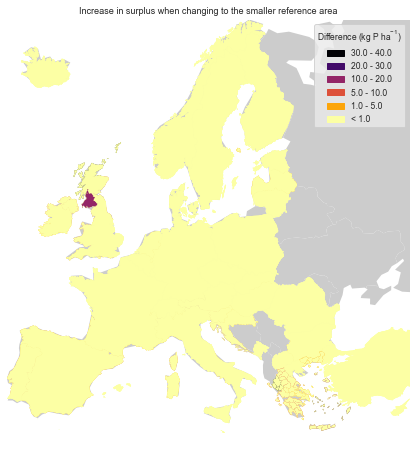

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
(
    nuts_geo[['geometry']]
    .join(surplus_diff)
    .pipe(
        plots.plot_europe_choropleth,
        'diff',
        bin_uls=[1, 5, 10, 20, 30, 40,],
        cmap=mpl.cm.inferno_r,
        ax=ax,
    )
)
ax.get_legend().set_title('Difference (kg P ha$^{-1}$)')
ax.set_title('Increase in surplus when changing to the smaller reference area')

# Why is Eurostat's surplus for Italy so much lower than ours?

Let's inspect data for Spain and France for comparison.

The most striking difference is that Italy's P harvest in fruit averages 9 kg P/ha UAA. Since fruit (including citrus) covers only 4% of Italy's UAA, this would correspond to a fruit P yield of > 200 kg P / ha. This is probably an error and the main cause that our balances are so different.

In [38]:
# Calculate major outputs per ha UAA (national average)
(
    eurostat_gnb
    .loc[['IT', 'ES', 'FR']]
    .pipe(lambda d: d.div(d.UAA, axis=0))
    .T
    .loc[lambda s: s.index.str.startswith('O_')]
    .join(eust.read_table_metadata('aei_pr_gnb')['dimensions'].loc['indic_ag'])
    .set_index('label')
    .round(2)
)

,IT,ES,FR
label,,,
Nutrient removal by crop residues burned on the field (tonnes of nutrient),NaN,0.61,0.00
Nutrient removal by harvest of crops (tonnes of nutrient),15.32,5.84,8.75
Nutrient removal by harvest of cereals (tonnes of nutrient),4.99,3.57,6.74
Nutrient removal by harvest of fruits (tonnes of nutrient),8.93,1.42,0.14
Nutrient removal by harvest of industrial crops (tonnes of nutrient),0.55,0.35,1.26
Nutrient removal by harvest of ornamental crops (tonnes of nutrient),NaN,0.03,0.00
Nutrient removal by harvest of other crops (tonnes of nutrient),NaN,0.00,0.00
Nutrient removal by harvest of dried pulses (tonnes of nutrient),0.04,0.11,0.11
Nutrient removal by harvest of root crops (tonnes of nutrient),0.16,0.05,0.38


In [39]:
areas = (
    eust.read_table_data('ef_lus_allcrops')
    .value
    .xs('HA', level='unit')
    .xs('TOTAL', level='agrarea')
    .xs('IT', level='geo')
    .xs(2013, level='time')
    .rename('Area')
    .to_frame()
    .join(eust.read_table_metadata('ef_lus_allcrops')['dimensions'].loc['crops'], on='crops')
    .reset_index()
    .set_index(['crops', 'label'])
    .loc[['UAA', 'ARA', 'PECR', 'J0000', 'F0000', 'T0000']]
    .assign(**{'Area share': lambda d: d.Area / d.Area.loc['UAA']})
)
areas

,,Area,Area share
crops,label,,
ARA,Arable land,6728360.0,NaN
F0000,"Fruits, berries and nuts (excluding citrus fruits, grapes and strawberries)",377470.0,NaN
J0000,Permanent grassland,3316430.0,NaN
PECR,Permanent crops,2032310.0,NaN
T0000,Citrus fruits,120180.0,NaN
UAA,Utilised Agricultural Area,12098890.0,1.0
